<a href="https://colab.research.google.com/github/qinyang-bao/rl-in-action/blob/master/IntroToRL_P1_TaxiV3_Solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# P1: Solve the OpenAI Gym [Taxi V3](https://gym.openai.com/envs/Taxi-v3/) Environment
---

## Introduction
[OpenAI Gym](https://gym.openai.com/docs/) is a framework that provides RL environments of varying complexity with the same standard API making it easy to develop and benchmark RL algorithms. The [Taxi-V3](https://gym.openai.com/envs/Taxi-v3/) environmnet present a simple, text environment where actions and state (observations) are both discrete. 

In [ ]:
import gym

The `gym.make()` API can be used to spawn any of the available environments by passing its full name.

In [ ]:
taxi = gym.make('Taxi-v3')

The Taxi environment has 500 states and 6 possible actions.

In [ ]:
taxi.action_space

Discrete(6)

In [ ]:
taxi.observation_space

Discrete(500)

The task and reward structure are described in the [documentation](https://github.com/openai/gym/blob/a5a6ae6bc0a5cfc0ff1ce9be723d59593c165022/gym/envs/toy_text/taxi.py#L25)

In [ ]:
taxi.reset()
taxi.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



## Submission
- Submit your solution as a Jupyter notebook. 
- Ensure that all cells in the notebook have been executed and the output is showing
- Ensure that your solution consistently reaches the average cumulative reward defined in the rubric (link below)
- Post your solution on Github and share the link to your commit as a direct message in Slack

##Evaluation
The goal of the project is to get a certain average (cumulative) reward over 100 episodes. To pass the project, you must meet all the requirments in the project rubric

### Q1, Describe the methods and variables in the class DiscreteEnv which is the parent class of the Taxi V3 class.
This class has the following member variables:
- nS: number of states
- nA: number of actions
- P: transitions table, which is a dictionary of lists, where `P[s][a] == [(probability, nextstate, reward, done), ...]`. Essentially, for any state action pair, this dictionary defines the probability to transition to all possible next state, and the reward associated with such transitions, as well as whether the episode will end afte rthe transition. 
- isd: initial state distribution, which is a list of length nS, specifiying the initial states. 
- lastaction : the last action taken by the agent
- action_space: possible actions, size set to nA
- observation_space: possible observations, size set to nS. This means all states are available(observable) to the agent.

This class has the following methods:
- __init__(self, nS, nA, P, isd): set nA, nS, P, isd as given. Create the action and observation spaces. Set random seed. Lastly, set initial state by sampling from the isd.
- seed(self): set the random seed for sampling from the action space and/or observation space.
- reset(self): reset the envirnoment. This includes resetting the current state by sampling the isd, and resetting lastaction to None.
- step(self, a): simulate one state transition based on the current state and the action. This is done by sampling the P (transition table) at the given state, action pair, using the transition probabilities for different next states at such state, action pair. 

### Q2, Describe the methods and variables in the Taxi V3 class.
This class has the following member variables:
- desc: this is the map stored as a numpy array.
- locs: the possible locations for passenger pick up locations and/or passenger drop off locations
- all the other members inherited from class DiscreteEnv. 

This class has the following methods:
- __init__(self): sets the desc and locs. It then fills the P (tranistions table) by iterating through each possible states and actions. The transition probability to any next state reachable by the chosen action is always set to 1. This means the state transitions are deterministic, any state action pair would lead to a predictable outcome. Asides from the tranistion probabilities, the next state, reward, and epsiode done are also set based on the outcome of the given state action pair. The possible initial states are also recorded while looping through the states, and afterwards the initial state distribution (isd) is created.   
Next, the generated P and isd, along with the nS and nA which are given based on the taxi v3 problem description, are passed to DiscreteEnv's constructor for
the remaining initialization steps.
- encode(self, taxi_row, taxi_col, pass_loc, dest_idx): this encodes the state to a single integer.
- decode(self, i): this recoves the state from a single integer. 
- render(self, mode='human'): this displays the current environment. When mode is set to "human", prints to stdout. Else is mode is set to "ansi", output to a file. 

### Q3, Describe the Taxi V3 environment, its actions, states, reward structure and the rationale behind such a reward structure.
There are six possible actions: 
- 0: move south
- 1: move north
- 2: move east
- 3: move west
- 4: pickup passenger
- 5: drop off passenger

There are 500 states (observations), because the map is 5x5, given 25 possible positions for the taxi; 4 possible destinations; and 5 possible locations of the passenger (4 pickup/drop off locations and 1 in taxi). 25 x 4 x 5 is 500 states.

The reward is:
- -1 for any step, except
- +20 for dropping off the passenger at the desired destination
- -10 for executing illegal drop off / pick up actions. The only legal pick up is when the passenger is not on taxi, and the taxi is at the passenger's pick up location. As for drop offs, any drop off at one of the destination locations is legal without the -10 penalties, but only a drop off at the passenger's desired destination will give the +20 reward. In otherwards, dropping off at the non-desired destination has the default -1 reward.


## See below cells for traning & evaluations


In [82]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [83]:
def epsilon_greedy_action_from_Q(Q, state, epsilon):
    actions = Q.columns
    action_probs = np.asarray([epsilon/len(actions)]*len(actions),dtype=np.float)
    
    greedy_action_index = np.argmax(Q.loc[state].values)
    action_probs[greedy_action_index] += 1-epsilon

    epsilon_greedy_action = np.random.choice(Q.columns,p=action_probs)
    
    return epsilon_greedy_action 

def greedy_action_from_Q(Q, state):
    return Q.loc[state].idxmax()  


In [117]:
def q_learning(Q, rewards, episodes, hyper_params, training=True):
  assert len(rewards) == hyper_params["n_episodes"]

  epsilon = hyper_params["init_epsilon"]

  illegal_action_detected = False

  # trainning loop, Q-learning
  for i in tqdm(range(hyper_params["n_episodes"])):
    taxi.reset()
    s0 = taxi.s
    done = False

    episode_reward = 0
    episode = []
    while not done:
      if training:
        a0 = epsilon_greedy_action_from_Q(Q,s0,epsilon)
        s1, reward, done, _  = taxi.step(a0)

        Q.loc[s0,a0] += hyper_params["alpha"]*(reward + hyper_params["gamma"]*Q.loc[s1].max() - Q.loc[s0,a0])
      # when we are not training, just use the greedy action, assuming our policy is optimum at this poiny of time
      else:
        a0 = greedy_action_from_Q(Q,s0)
        s1, reward, done, _  = taxi.step(a0)
      
      # record reward and episode
      episode_reward += reward
      episode.append((s1, reward, done, _))

      # check if we have an illegal action
      if reward == -10:
        illegal_action_detected = True

      s0 = s1
    
    # epsilon decay
    epsilon *= hyper_params["epsilon_decay"]
    epsilon = max(epsilon, hyper_params["min_epsilon"])

    rewards[i] = episode_reward
    episodes.append(episode)

  return illegal_action_detected

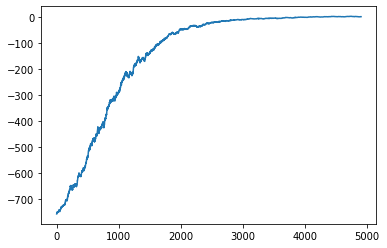

In [93]:
Q = pd.DataFrame.from_dict({s:{a:0 for a in range(taxi.nA)} for s in range(taxi.nS)}, orient='index')

hyper_params = {"n_episodes": 5000, "init_epsilon": 1, "min_epsilon": 0.1, "epsilon_decay": 0.9995, "alpha": 0.05, "gamma": 0.9}

rewards = np.zeros(hyper_params["n_episodes"])
episodes = []

q_learning(Q, rewards, episodes, hyper_params)

windowed_rewards = np.convolve(rewards, np.ones(100), 'valid')
windowed_rewards = windowed_rewards/100
plt.plot(windowed_rewards)
plt.show()

In [94]:
np.percentile(windowed_rewards[-1000:], q=[5, 95])

array([-0.43  ,  2.9205])

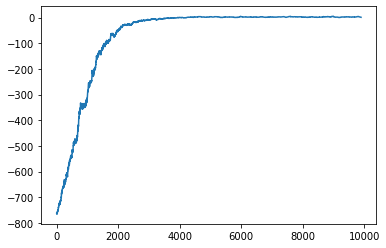

In [95]:
Q = pd.DataFrame.from_dict({s:{a:0 for a in range(taxi.nA)} for s in range(taxi.nS)}, orient='index')

hyper_params = {"n_episodes": 10000, "init_epsilon": 1, "min_epsilon": 0.1, "epsilon_decay": 0.9995, "alpha": 0.05, "gamma": 0.9}

rewards = np.zeros(hyper_params["n_episodes"])
episodes = []

q_learning(Q, rewards, episodes, hyper_params)

windowed_rewards = np.convolve(rewards, np.ones(100), 'valid')
windowed_rewards = windowed_rewards/100
plt.plot(windowed_rewards)
plt.show()

In [96]:
np.percentile(windowed_rewards[-1000:], q=[5, 95])

array([0.6595, 4.0905])

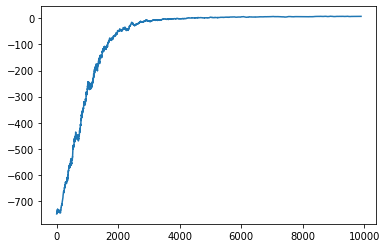

In [97]:
Q = pd.DataFrame.from_dict({s:{a:0 for a in range(taxi.nA)} for s in range(taxi.nS)}, orient='index')

hyper_params = {"n_episodes": 10000, "init_epsilon": 1, "min_epsilon": 0, "epsilon_decay": 0.9995, "alpha": 0.05, "gamma": 0.9}

rewards = np.zeros(hyper_params["n_episodes"])
episodes = []

q_learning(Q, rewards, episodes, hyper_params)

windowed_rewards = np.convolve(rewards, np.ones(100), 'valid')
windowed_rewards = windowed_rewards/100
plt.plot(windowed_rewards)
plt.show()

In [98]:
np.percentile(windowed_rewards[-1000:], q=[5, 95])

array([7.16, 8.08])

### First attempt to evalute policy

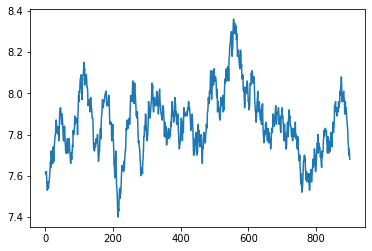

In [126]:
Q_trained = Q.copy()
hyper_params["n_episodes"] = 1000

rewards = np.zeros(hyper_params["n_episodes"])
episodes = []

illegal_action_detected = q_learning(Q_trained, rewards, episodes, hyper_params, training=False)

windowed_rewards = np.convolve(rewards, np.ones(100), 'valid')
windowed_rewards = windowed_rewards/100
plt.plot(windowed_rewards)
plt.show()


In [127]:
print(np.percentile(windowed_rewards[-1000:], q=[5, 95]))
print(illegal_action_detected)

[7.61 8.11]
False


### More hyper parameter tuning

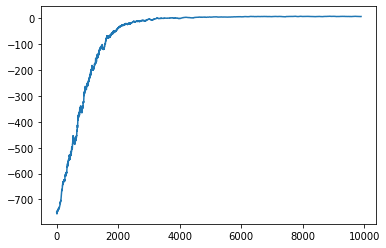

In [130]:
Q = pd.DataFrame.from_dict({s:{a:0 for a in range(taxi.nA)} for s in range(taxi.nS)}, orient='index')

hyper_params = {"n_episodes": 10000, "init_epsilon": 1, "min_epsilon": 0, "epsilon_decay": 0.9994, "alpha": 0.05, "gamma": 0.9}

rewards = np.zeros(hyper_params["n_episodes"])
episodes = []

q_learning(Q, rewards, episodes, hyper_params)

windowed_rewards = np.convolve(rewards, np.ones(100), 'valid')
windowed_rewards = windowed_rewards/100
plt.plot(windowed_rewards)
plt.show()

In [131]:
print(np.percentile(windowed_rewards[-1000:], q=[5, 95]))


[7.28   8.1005]


###Q4, Train an algorithm to achieve a 100-episode average reward with a 5th percentile of 7.2 or higher and a 95th percentile of 8.2 or higher on the last 1000 episodes.

###Q5,The algorithm should be able to perform pick-ups and dropoffs with zero penalties over 1000 episodes.


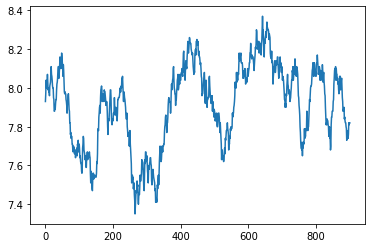

[7.53 8.22]
False


In [135]:
Q_trained = Q.copy()
hyper_params["n_episodes"] = 1000

rewards = np.zeros(hyper_params["n_episodes"])
episodes = []

illegal_action_detected = q_learning(Q_trained, rewards, episodes, hyper_params, training=False)

windowed_rewards = np.convolve(rewards, np.ones(100), 'valid')
windowed_rewards = windowed_rewards/100
plt.plot(windowed_rewards)
plt.show()
print(np.percentile(windowed_rewards[-1000:], q=[5, 95]))
print(illegal_action_detected)

###Q6, Document your solution including all hyper parameters and how those hyperparameters were selected.
I start with the default hyper params used in foolsball:  
`hyper_params = {"n_episodes": 5000, "init_epsilon": 1, "min_epsilon": 0.1, "epsilon_decay": 0.9995, "alpha": 0.01, "gamma": 0.9}`

I looked at the plot of the windowed_rewards, it the rewards is steadily increasing for the 5000 episodes, but at the end, it acheived around -100~-200. This tells that we should either train longer, or make the learning quicker. 

In the interest of time, I decided to make the training quicker. I first tried to increase alpha to 0.05. After 5000 epsiodes, the last 1000 episodes has a 5th percentile of -0.43 and a 95th percentile of 2.9205. The plt of windowed_rewards appears to have plateaued. But this is just a visual observation. After all, the desired rewards is around ~10 which is miniscule on the plt as early episodes have rewards -700 ~ - 500.

To see if the trainning has really converged, I decided to train it longer, for 10000 episodes. This time, we reached a 5th percentile of 0.6595 and a 95th percentile of 4.0905. This is still less than the desired, and not much of an improvement from the 5000 episodes. It appears our training has indeed plateaued and converged. We should tune some other hyperparameters. 

It could be that the min_epsilon is too high, such that the agent still takes random actions when we have obtained the optimum policy; thus, making the rewards lower than desired. So, I changed the min_epsilon to 0 (although it would never be reached since we use exponential decay), and tried again. The result is indeed better, now we are at 5th percentile of 7.16 and a 95th percentile of 8.08. This is very close to the target. The small difference could be just due to the extremely small but non-zero episolen. So I decided to evalute the trianed Q table, with pure greedy action selection.

I tried to evaluate several times, most of the times the reward is at the desired target, but not always. This could suggest that with some of the combinations of the initial conditions (initial conditions are randomly selected), the policy does not handle optimally. This might be a result of insufficient exploitation, so I decided to make epsilon decay faster, setting epsilon_decay to 0.9994 and tried again. This gives a 5th percentile of 7.28 and a 95th percentile of 8.1005. This is a slight improvement, and could be just what we need to meet the target.

Switching to pure greedy action selection, I evaluated for 1000 episodes again, and this time, the results are consistently meeting the target (ran the cell above this one for several times, and each time we exceed the target).